# ML/AI Best Practices: "Selecting Surrogate Model Form/Size for Optimization"

In this notebook we demonstrate the use of model and solver statistics to select the best surrogate model. For this purpose we trained (offline) different models with ALAMO, PySMO for three basis forms, and TensorFlow Keras. The surrogates are imported into the notebook, and the IDAES flowsheet is constructed and solved.

## 1. Introduction

This example demonstrates autothermal reformer optimization leveraging the ALAMO, PySMO and Keras surrogate trainers, and compares key indicators of model performance. In this notebook, IPOPT will be run with statistics using ALAMO, PySMO Polynomial, PySMO RBF, PySMO Kriging and Keras surrogate models to assess each model type for flowsheet integration and tractability.

## 2. Problem Statement 

Within the context of a larger Natural Gas Fuel Cell (NGFC) system, the autothermal reformer unit is used to generate syngas from air, steam, and natural gas. Two input variables are considered for this example (reformer bypass fraction and fuel to steam ratio). The reformer bypass fraction (also called internal reformation percentage) plays an important role in the syngas final composition and it is typically controlled in this process. The fuel to steam ratio is an important variable that affects the final syngas reaction and heat duty required by the reactor.  The syngas is then used as fuel by a solid-oxide fuel cell (SOFC) to generate electricity and heat. 

The autothermal reformer is typically modeled using the IDAES Gibbs reactor and this reactor is robust once it is initialized; however, the overall model robustness is affected due to several components present in the reaction, scaling issues for the largrangean multipliers, and Gibbs free energy minimization formulation. Substituting rigorously trained and validated surrogates in lieu of rigorous unit model equations increases the robustness of the problem.

### 2.1. Inputs: 
- Bypass fraction (dimensionless) - split fraction of natural gas to bypass AR unit and feed directly to the power island
- NG-Steam Ratio (dimensionless) - proportion of natural relative to steam fed into AR unit operation

### 2.2. Outputs:
- Steam flowrate (kg/s) - inlet steam fed to AR unit
- Reformer duty (kW) - required energy input to AR unit
- Composition (dimensionless) - outlet mole fractions of components (Ar, C2H6, C3H8, C4H10, CH4, CO, CO2, H2, H2O, N2, O2)

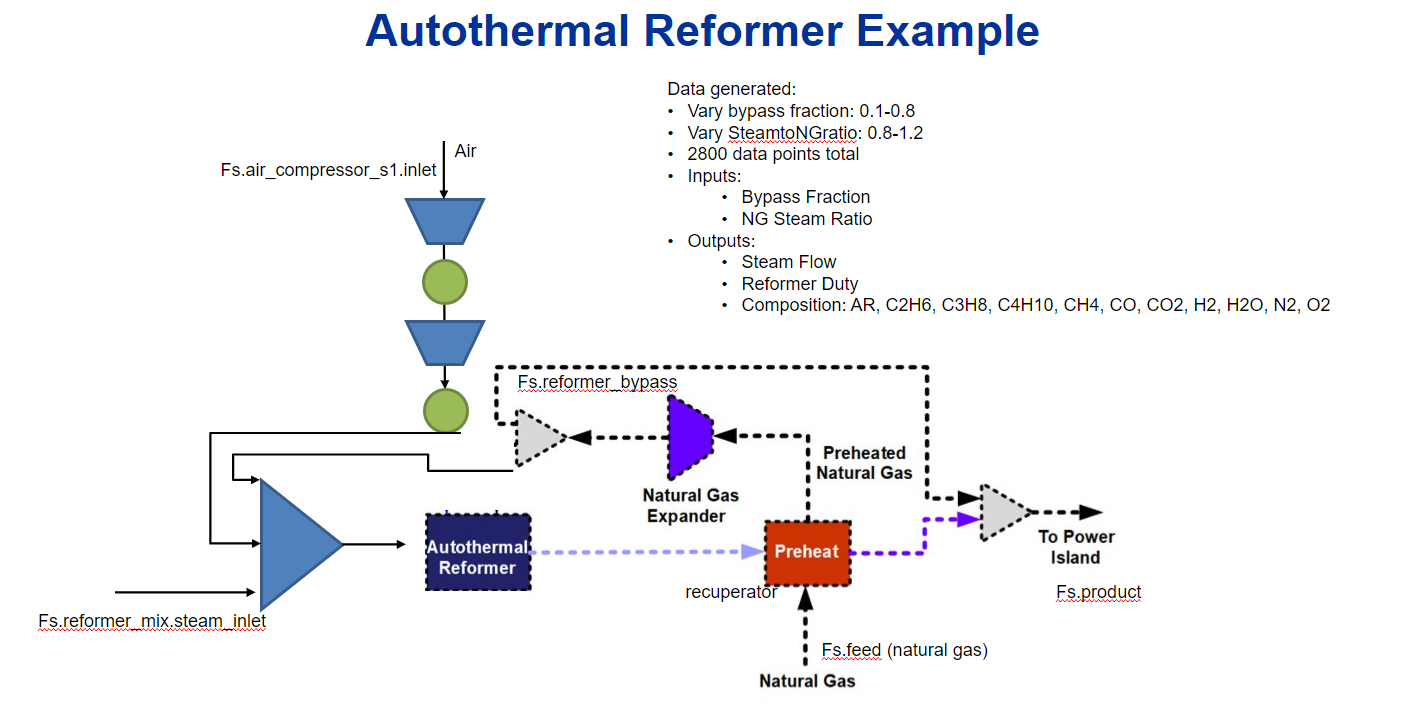

In [1]:
from IPython.display import Image
Image("AR_PFD.png")

## 3. Training Surrogates

Previous Jupyter Notebooks demonstrated the workflow to import data, train surrogate models using [ALAMO](ALAMO_flowsheet_optimization.ipynb), [PySMO](PySMO_flowsheet_optimization.ipynb) and [Keras](Keras_flowsheet_optimization.ipynb), and develop IDAES's validation plots. To keep this notebook simple, this notebook simply loads the surrogate models trained off line.

Note that the training/loading method includes a "retrain" argument in case the user wants to retrain all surrogate models. Since the retrain method runs ALAMO, PySMO (Polynomial, Radial Basis Functions, and Kriging basis types) and Keras, it takes about an 1 hr to complete the training for all models.

Each run will overwrite the serialized JSON files for previously trained surrogates if retraining is enforced. To retrain individual surrogates, simply delete the desired JSON before running this notebook (for Keras, delete the folder `keras_surrogate/`)

In [2]:
from AR_training_methods import train_load_surrogates

train_load_surrogates(retrain=False)
# setting retrain to True will take ~ 1 hour to run, best to load if possible
# setting retrain to False will only generate missing surrogates (only if JSON/folder doesn't exist)
# this method trains surrogates and serializes to JSON, so no objects are returned from the method itself

# imports to capture long output
from io import StringIO
import sys

Loading existing surrogate models and training missing models.
Any training output will print below; otherwise, models will be loaded without any further output.


# 4. Build and Run IDAES Flowsheet

This step builds an IDAES flowsheet and imports the surrogate model objects. As shown in the prior three examples, a single model object accounts for all input and output variables, and the JSON model serialized earlier may be imported into a single SurrogateBlock() component. While the serialization method and file structure differs slightly between the ALAMO, PySMO and Keras Python Wrappers, the three are imported similarly into IDAES flowsheets as shown below.

## 4.1 Build IDAES Flowsheet

This method builds an instance of the IDAES flowsheet model and solves the flowsheet using IPOPT. The method allows users to select a case and the surrogate model type to be used (i.e., alamo, pysmo, keras). The case argument consists of a list with values for the input variables (in this order, bypass split fraction and natural gas to steam ratio). Then the method fixes the input variables values to solve a square problem with IPOPT. 

In [3]:
# Import IDAES and Pyomo libraries
from pyomo.environ import ConcreteModel, SolverFactory, value, Var, \
    Constraint, Set
from pyomo.contrib.parmest.utils.ipopt_solver_wrapper import ipopt_solve_with_stats
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core.surrogate.alamopy import AlamoSurrogate
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate
from idaes.core.surrogate.keras_surrogate import KerasSurrogate
from idaes.core import FlowsheetBlock

def build_flowsheet(case, surrogate_type='alamo'):
    print(case, ' ', surrogate_type)
    # create the IDAES model and flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    # create flowsheet input variables
    m.fs.bypass_frac = Var(initialize=0.80, bounds=[0.1, 0.8], doc='natural gas bypass fraction')
    m.fs.ng_steam_ratio = Var(initialize=0.80, bounds=[0.8, 1.2], doc='natural gas to steam ratio')

    # create flowsheet output variables
    m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
    m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
    m.fs.AR = Var(initialize=0, doc="AR fraction")
    m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
    m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
    m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
    m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
    m.fs.CO = Var(initialize=0, doc="CO fraction")
    m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
    m.fs.H2 = Var(initialize=0, doc="H2 fraction")
    m.fs.H2O = Var(initialize=0, doc="H2O fraction")
    m.fs.N2 = Var(initialize=0, doc="N2 fraction")
    m.fs.O2 = Var(initialize=0, doc="O2 fraction")

    # create input and output variable object lists for flowsheet
    inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
    outputs = [m.fs.steam_flowrate, m.fs.reformer_duty, m.fs.AR, m.fs.C2H6, m.fs.C3H8,
               m.fs.C4H10, m.fs.CH4, m.fs.CO, m.fs.CO2, m.fs.H2, m.fs.H2O, m.fs.N2, m.fs.O2]

    # create the Pyomo/IDAES block that corresponds to the surrogate
    # call correct PySMO object to use below (will let us avoid nested switches)
    
    # capture long output from loading surrogates (don't need to print it)
    stream = StringIO()
    oldstdout = sys.stdout
    sys.stdout = stream
        
    if surrogate_type=='alamo':
        surrogate = AlamoSurrogate.load_from_file('alamo_surrogate.json')
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    elif surrogate_type=='keras':
        keras_surrogate = KerasSurrogate.load_from_folder('keras_surrogate')
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(keras_surrogate,
                                   formulation=KerasSurrogate.Formulation.FULL_SPACE,
                                   input_vars=inputs, output_vars=outputs)
    else:  # surrogate is one of the three pysmo basis options
        surrogate = PysmoSurrogate.load_from_file(str(surrogate_type) + '_surrogate.json')
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    
    # revert to standard output
    sys.stdout = oldstdout

    # fix input values and solve flowsheet
    m.fs.bypass_frac.fix(case[0])
    m.fs.ng_steam_ratio.fix(case[1])

    solver = SolverFactory('ipopt')
    try:  # attempt to solve problem
        [status_obj, solved, iters, time, regu] = ipopt_solve_with_stats(m, solver)
    except:  # retry solving one more time
        [status_obj, solved, iters, time, regu] = ipopt_solve_with_stats(m, solver)

    return (status_obj['Problem'][0]['Number of variables'],
            status_obj['Problem'][0]['Number of constraints'],
            value(m.fs.steam_flowrate), value(m.fs.reformer_duty),
            value(m.fs.C2H6), value(m.fs.CH4), value(m.fs.H2), value(m.fs.O2),
            value(iters), value(time)) # don't report regu

## 4.2 Model Size/Form Comparison

As mentioned above, as part of best practices the IDAES ML/AI demonstration includes the analysis of model/solver statistics and performance to determine the best surrogate model, including model size, model form, model trainer, etc. This section provides the rigorous analysis of solver performance comparing differnt surrogate models (ALAMO, PySMO polynomial, PysMO RBF, and PySMO Kriging).

To obtain the results, we run the flowsheet for ten different simulation cases for each surrogate model type. We collect and compare IPOPT iterations and runtime statistics. Additionally, since the simulation cases are obtained from the training data set we can also compare model performance (absolute error of measurement vs predicted output values).

In [4]:
# Import Auto-reformer training data
import numpy as np
import pandas as pd
np.set_printoptions(precision=6, suppress=True)
csv_data = pd.read_csv(r'reformer-data.csv') # 2800 data points

# extracting 10 data points out of 2800 data points, randomly selecting 10 cases to run
case_data = csv_data.sample(n = 10)

# selecting columns that correspond to Input Variables
inputs = np.array(case_data.iloc[:, :2])

# selecting columns that correspod to Output Variables
cols = ["Steam_Flow", "Reformer_Duty", "C2H6", "CH4", "H2", "O2"] 
outputs = np.array(case_data[cols])

# For results comparison with minimum memory usage we will extract the values to plot on each pass
# note that the entire model could be returned and saved on each loop if desired

# create empty dictionaries so we may easily index results as we save them
# for convenience while plotting, each output variable has its own dictionary
# indexed by (case number, trainer type)
trainers = ['alamo', 'pysmo_poly', 'pysmo_rbf', 'pysmo_krig', 'keras']
cases = range(len(inputs))
model_vars = {}
model_cons = {}
steam_flow_error = {}
reformer_duty_error = {}
conc_C2H6 = {}
conc_CH4 = {}
conc_H2 = {}
conc_O2 = {}
ipopt_iters = {}
ipopt_time = {}

# run flowsheet for each trainer and save results
i = 0
for case in inputs: # each case is a value pair (bypass_frac, ng_steam_ratio)
    i = i + 1
    for trainer in trainers:
        [numvar, numcon, sf, rd, eth, meth, hyd, oxy, iters, time] = build_flowsheet(case, surrogate_type=trainer)
        model_vars[trainer] = numvar  # will be overwritten, but has the same values for all cases
        model_cons[trainer] = numcon  # will be overwritten, but has the same values for all cases
        steam_flow_error[(i, trainer)] = abs((sf - value(outputs[i-1,0]))/value(outputs[i-1,0]))
        reformer_duty_error[(i, trainer)] = abs((rd - value(outputs[i-1,1]))/value(outputs[i-1,1]))
        conc_C2H6[(i, trainer)] = abs(eth - value(outputs[i-1,2]))
        conc_CH4[(i, trainer)] = abs(meth - value(outputs[i-1,3]))
        conc_H2[(i, trainer)] = abs(hyd - value(outputs[i-1,4]))
        conc_O2[(i, trainer)] = abs(oxy - value(outputs[i-1,5]))
        ipopt_iters[(i, trainer)] = iters
        ipopt_time[(i, trainer)] = time

[0.373913 1.073684]   alamo
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp43172s_lipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.373913 1.073684]   pysmo_krig
2023-01-17 07:54:42 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpuph1y_uwipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sal

[0.394203 0.936842]   pysmo_poly
2023-01-17 07:54:43 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp8rcnlph5ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales 

[0.394203 0.936842]   keras
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp3mey8qw3ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.789855 0.978947]   pysmo_rbf
2023-01-17 07:54:46 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpo103e1lzipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales an

[0.191304 0.936842]   alamo
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmptzfy6a6mipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.191304 0.936842]   pysmo_krig
2023-01-17 07:54:48 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp0ktm9_5_ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sal

[0.231884 0.863158]   pysmo_poly
2023-01-17 07:54:50 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpwyfz0dbcipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales 

[0.231884 0.863158]   keras
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpk1qrw0geipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.150725 0.978947]   pysmo_rbf
2023-01-17 07:54:52 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp9uv1fokeipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales an

[0.728986 0.8     ]   alamo
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmppmbukqw7ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.728986 0.8     ]   pysmo_krig
2023-01-17 07:54:55 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp33vlcvu1ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sal

[0.1      1.052632]   pysmo_poly
2023-01-17 07:54:56 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpzsbddr1oipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales 

[0.1      1.052632]   keras
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpu10iv1kgipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.181159 0.915789]   pysmo_rbf
2023-01-17 07:54:59 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpxt137em3ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales an

[0.668116 1.073684]   alamo
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpse93uqooipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the f

[0.668116 1.073684]   pysmo_krig
2023-01-17 07:55:02 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=kriging
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpuytavha0ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sal

We can visualize these results by plotting a graph for each of the quantities above, creating a data series for each surrogate trainer. Some data series may overlay if values are identical for all cases:

Note: PySMO generates identical IPOPT model size (model constraints and variables) regardless of surrogate expression size.


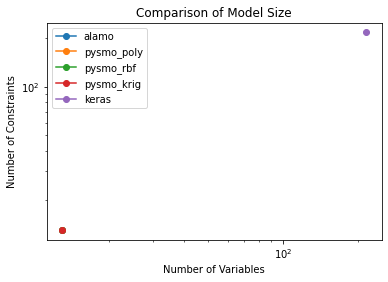


Process variable predictions displayed with relative error:



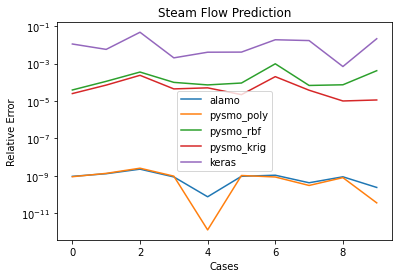

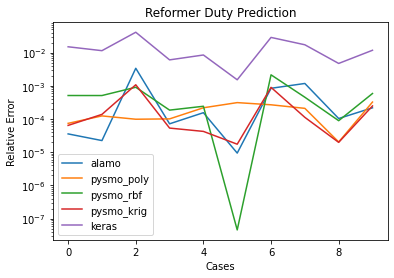

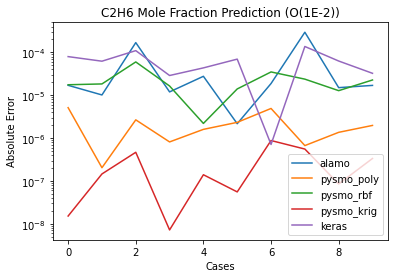


Mole fraction predictions displayed with absolute error:



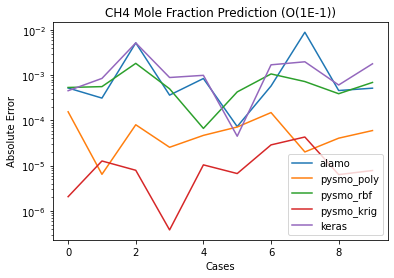

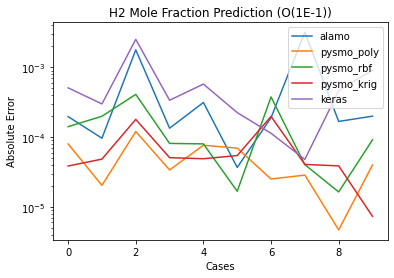

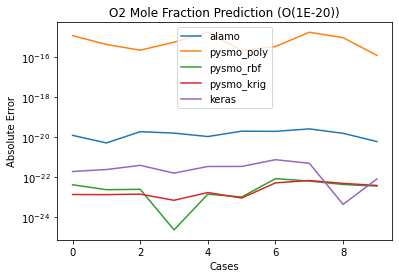

In [5]:
from matplotlib import pyplot as plt

# create figure/axes for each plot sequentially, plotting each trainer as a separate data series

# Comparing model sizes
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # plot number of constraints vs number of variables for each trainer
    sf = [steam_flow_error[(i,j)] for (i,j) in steam_flow_error if j == trainer]
    ax.plot(model_vars[trainer], model_cons[trainer], label=trainer, marker='o')
# add info to plot
ax.set_xlabel('Number of Variables')
ax.set_ylabel('Number of Constraints')
ax.set_title('Comparison of Model Size')
ax.legend()
plt.yscale('log')
plt.xscale('log')
print('Note: PySMO generates identical IPOPT model size (model constraints and variables) '
      'regardless of surrogate expression size.')
plt.show()

print()
print('Process variable predictions displayed with relative error:')
print()

# Steam Flow Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    sf = [steam_flow_error[(i,j)] for (i,j) in steam_flow_error if j == trainer]
    ax.plot(cases, sf, label=trainer)
# add info to plot
ax.set_xlabel('Cases')
ax.set_ylabel('Relative Error')
ax.set_title('Steam Flow Prediction')
ax.legend()
plt.yscale('log')
plt.show()

# Reformer Duty Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    rd = [reformer_duty_error[(i,j)] for (i,j) in reformer_duty_error if j == trainer]
    ax.plot(cases, rd, label=trainer)
# add info to plot
ax.set_xlabel('Cases')
ax.set_ylabel('Relative Error')
ax.set_title('Reformer Duty Prediction')
ax.legend()
plt.yscale('log')
plt.show()

# C2H6 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    eth = [conc_C2H6[(i,j)] for (i,j) in conc_C2H6 if j == trainer]
    ax.plot(cases, eth, label=trainer)
# add info to plot
ax.set_xlabel('Cases')
ax.set_ylabel('Absolute Error')
ax.set_title('C2H6 Mole Fraction Prediction (O(1E-2))')
ax.legend()
plt.yscale('log')
plt.show()

print()
print('Mole fraction predictions displayed with absolute error:')
print()

# CH4 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    meth = [conc_CH4[(i,j)] for (i,j) in conc_CH4 if j == trainer]
    ax.plot(cases, meth, label=trainer)
# add info to plot
ax.set_xlabel('Cases')
ax.set_ylabel('Absolute Error')
ax.set_title('CH4 Mole Fraction Prediction (O(1E-1))')
ax.legend()
plt.yscale('log')
plt.show()

# H2 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    hyd = [conc_H2[(i,j)] for (i,j) in conc_H2 if j == trainer]
    ax.plot(cases, hyd, label=trainer)
# add info to plot
ax.set_xlabel('Cases')
ax.set_ylabel('Absolute Error')
ax.set_title('H2 Mole Fraction Prediction (O(1E-1))')
ax.legend()
plt.yscale('log')
plt.show()

# O2 Mole Fraction Prediction
fig = plt.figure()
ax = fig.add_subplot()
for trainer in trainers:
    # pick out the points that use that trainer and plot them against case number
    oxy = [conc_O2[(i,j)] for (i,j) in conc_O2 if j == trainer]
    ax.plot(cases, oxy, label=trainer)
# add info to plot
ax.set_xlabel('Cases')
ax.set_ylabel('Absolute Error')
ax.set_title('O2 Mole Fraction Prediction (O(1E-20))')
ax.legend()
plt.yscale('log')
plt.show()

## 4.3 Comparing Surrogate Optimization
Extending this analysis, we will run a single optimization scenario for each surrogate model and compare results. As in previous examples detailing workflows for [ALAMO](ALAMO_flowsheet_optimization.ipynb), [PySMO](PySMO_flowsheet_optimization.ipynb) and [Keras](Keras_flowsheet_optimization.ipynb), we will optimize hydrogen production while restricting nitrogen below 34 mol% in the product stream.

In [6]:
# Import additional Pyomo libraries
from pyomo.environ import Objective, maximize

def run_optimization(surrogate_type='alamo'):
    print(surrogate_type)
    # create the IDAES model and flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    # create flowsheet input variables
    m.fs.bypass_frac = Var(initialize=0.80, bounds=[0.1, 0.8], doc='natural gas bypass fraction')
    m.fs.ng_steam_ratio = Var(initialize=0.80, bounds=[0.8, 1.2], doc='natural gas to steam ratio')

    # create flowsheet output variables
    m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
    m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
    m.fs.AR = Var(initialize=0, doc="AR fraction")
    m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
    m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
    m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
    m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
    m.fs.CO = Var(initialize=0, doc="CO fraction")
    m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
    m.fs.H2 = Var(initialize=0, doc="H2 fraction")
    m.fs.H2O = Var(initialize=0, doc="H2O fraction")
    m.fs.N2 = Var(initialize=0, doc="N2 fraction")
    m.fs.O2 = Var(initialize=0, doc="O2 fraction")

    # create input and output variable object lists for flowsheet
    inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
    outputs = [m.fs.steam_flowrate, m.fs.reformer_duty, m.fs.AR, m.fs.C2H6, m.fs.C3H8,
               m.fs.C4H10, m.fs.CH4, m.fs.CO, m.fs.CO2, m.fs.H2, m.fs.H2O, m.fs.N2, m.fs.O2]

    # create the Pyomo/IDAES block that corresponds to the surrogate
    # call correct PySMO object to use below (will let us avoid nested switches)
    
    # capture long output from loading surrogates (don't need to print it)
    stream = StringIO()
    oldstdout = sys.stdout
    sys.stdout = stream
        
    if surrogate_type=='alamo':
        surrogate = AlamoSurrogate.load_from_file('alamo_surrogate.json')
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    elif surrogate_type=='keras':
        keras_surrogate = KerasSurrogate.load_from_folder('keras_surrogate')
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(keras_surrogate,
                                   formulation=KerasSurrogate.Formulation.FULL_SPACE,
                                   input_vars=inputs, output_vars=outputs)
    else:  # surrogate is one of the three pysmo basis options
        surrogate = PysmoSurrogate.load_from_file(str(surrogate_type) + '_surrogate.json')
        m.fs.surrogate = SurrogateBlock()
        m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)
    
    # revert to standard output
    sys.stdout = oldstdout

    # unfix input values and add the objective/constraint to the model
    m.fs.bypass_frac.unfix()
    m.fs.ng_steam_ratio.unfix()
    m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
    m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

    solver = SolverFactory('ipopt')
    try:  # attempt to solve problem
        [status_obj, solved, iters, time, regu] = ipopt_solve_with_stats(m, solver)
    except:  # retry solving one more time
        [status_obj, solved, iters, time, regu] = ipopt_solve_with_stats(m, solver)

    return inputs, outputs, iters, time # don't report regu

In [7]:
# create list objects to store data, run optimization
results = {}
for trainer in trainers:
    inputs, outputs, iters, time = run_optimization(trainer)
    results[('IPOPT iterations', trainer)] = iters
    results[('Solve time', trainer)] = time
    for var in inputs:
        results[(var.name, trainer)] = value(var)
    for var in outputs:
        results[(var.name, trainer)] = value(var)

alamo
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp1i0ket2oipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgeme

pysmo_rbf
2023-01-17 07:55:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpe1m167woipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity materi

keras
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmpjrv5w496ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgeme

In [8]:
# print results as a table
df_index = ['IPOPT iterations', 'Solve time']
for var in inputs:
    df_index.append(var.name)
for var in outputs:
    df_index.append(var.name)
df_cols = trainers

df = pd.DataFrame(index = df_index, columns = df_cols)
for i in df_index:
    for j in df_cols:
        df[j][i] = results[(i, j)]

df  # display results table

,alamo,pysmo_poly,pysmo_rbf,pysmo_krig,keras
IPOPT iterations,19,13,14,13,13
Solve time,0.009,0.008,0.015,0.009,0.026
fs.bypass_frac,0.111507,0.1,0.1,0.1,0.1
fs.ng_steam_ratio,1.2,1.115033,1.124305,1.124276,1.115032
fs.steam_flowrate,1.292076,1.216139,1.226153,1.226191,1.190826
fs.reformer_duty,40059.758233,38885.573262,39062.177089,39072.795322,38000.779477
fs.AR,0.004109,0.004107,0.004107,0.004107,0.004118
fs.C2H6,0.000119,0.00053,0.000545,0.000519,0.000392
fs.C3H8,0.000026,0.000116,0.000119,0.000114,0.000099
fs.C4H10,0.000015,0.000066,0.000068,0.000065,0.000051
